## Setup + imports

In [1]:
# === Core Python / ML / CV Libraries ===
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from patchify import patchify, unpatchify
import pandas as pd

# === ML Model ===
from keras.models import load_model
from keras import backend as K

# === Morphological Tools ===
from skimage import morphology
from skimage.morphology import skeletonize
from skan.csr import skeleton_to_csgraph
import networkx as nx
import random

# === PyBullet Sim ===
import pybullet as p
import time
from PID_Controller import PID
from sim_class import Simulation
import imageio
frames = []

# === Constants ===
PATCH_SIZE = 256
TOP_Y_THRESHOLD = 1000  # For filtering
SIZE_THRESHOLD = 200
KERNEL_SIZE = (32, 32)  # Final closing kernel
EXAMPLE_MODEL_PATH = r"C:\Users\batkm\Documents\Github\2024-25b-fai2-adsai-MichalBatkowski1232079\Deliverables\task 5\michal_232079_unet_model_v3_256px.h5"
MODEL = load_model(EXAMPLE_MODEL_PATH, custom_objects={"f1": lambda y_true, y_pred: y_pred})  # F1 used only for training




## Get Plate Image + Preprocess for Inference

[SIM] Simulation initialized.
[SIM] Retrieved specimen image path:
    textures/_plates/035_43-17-ROOT1-2023-08-08_mock_pH5_+Fe_Col0_04-Fish Eye Corrected.png


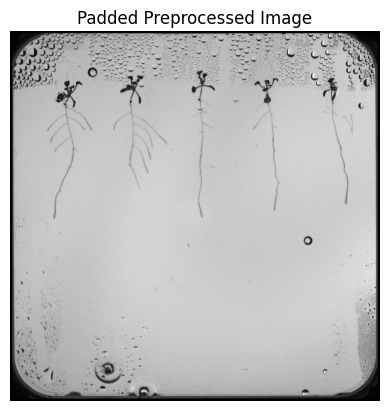

In [2]:
# === Initialize Simulation ===
sim = Simulation(num_agents=1, render=True)
print("[SIM] Simulation initialized.")

# === Get Specimen Plate Image from Simulator ===
image_path = sim.get_plate_image()
print(f"[SIM] Retrieved specimen image path:\n    {image_path}")


# === Load Image in Grayscale ===
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# === Crop & Format Functions ===
def crop_initial(image, initial_crop=100):
    return image[:, initial_crop:-initial_crop][:-initial_crop, :]

def find_edges(line, threshold=70):
    left_edge, right_edge = None, None
    n = len(line)
    for i in range(1, n):
        if line[i - 1] < threshold <= line[i] or line[i - 1] >= threshold > line[i]:
            left_edge = i
            break
    for i in range(n - 1, 0, -1):
        if line[i] < threshold <= line[i - 1] or line[i] >= threshold > line[i - 1]:
            right_edge = i
            break
    return left_edge, right_edge

def format_crop(image):
    horizontal_line = image[image.shape[0] // 2, :]
    vertical_line = image[:, image.shape[1] // 2]
    left_x, right_x = find_edges(horizontal_line)
    top_y, bottom_y = find_edges(vertical_line)
    side_length = max(right_x - left_x, bottom_y - top_y)
    right_x = left_x + side_length
    bottom_y = top_y + side_length
    return image[top_y:bottom_y, left_x:right_x]

# === Preprocess Image ===
cropped = crop_initial(image)
formatted = format_crop(cropped)
h, w = formatted.shape
pad_h = ((h // PATCH_SIZE) + 1) * PATCH_SIZE - h
pad_w = ((w // PATCH_SIZE) + 1) * PATCH_SIZE - w
pad_top, pad_bottom = pad_h // 2, pad_h - (pad_h // 2)
pad_left, pad_right = pad_w // 2, pad_w - (pad_w // 2)

padded_image = cv2.copyMakeBorder(
    formatted, pad_top, pad_bottom, pad_left, pad_right,
    cv2.BORDER_CONSTANT, value=0
)

# === Show the Preprocessed Image ===
plt.imshow(padded_image, cmap='gray')
plt.title("Padded Preprocessed Image")
plt.axis('off')
plt.show()


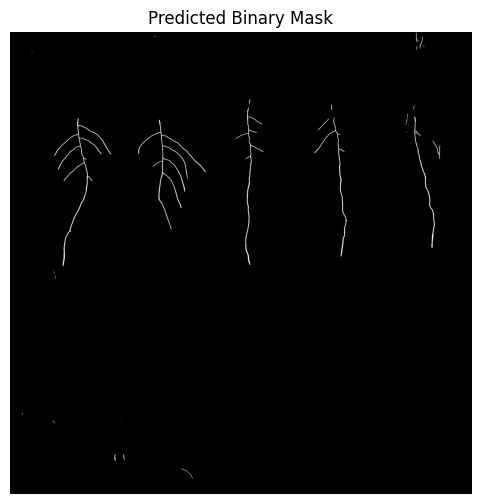

In [3]:
from patchify import patchify, unpatchify

# === Normalize and Patch ===
padded_input = np.repeat(padded_image[..., np.newaxis], 3, axis=-1) / 255.0
patches = patchify(padded_input, (PATCH_SIZE, PATCH_SIZE, 3), step=PATCH_SIZE)
patches_flat = patches.reshape(-1, PATCH_SIZE, PATCH_SIZE, 3)

# === Run Inference ===
preds = MODEL.predict(patches_flat, verbose=0)
preds_bin = (preds > 0.5).astype(np.uint8).reshape(patches.shape[0], patches.shape[1], PATCH_SIZE, PATCH_SIZE)
pred_mask = unpatchify(preds_bin, padded_image.shape[:2])

# === Remove Padding ===
predicted_mask = pred_mask[pad_top:-pad_bottom, pad_left:-pad_right]

# === Visualize ===
plt.figure(figsize=(6, 6))
plt.imshow(predicted_mask, cmap='gray')
plt.title("Predicted Binary Mask")
plt.axis("off")
plt.show()


## Run Inference and Extract Root Bottom Tips

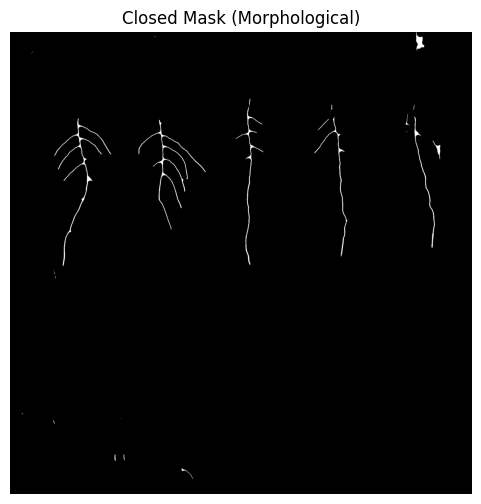

In [4]:
def preprocess_single_mask(mask, kernel_size=(32, 32)):
    """
    Apply morphological closing to a single predicted mask.
    """
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, kernel_size)
    closed_mask = cv2.morphologyEx(mask.astype(np.uint8), cv2.MORPH_CLOSE, kernel)

    # Visualize
    plt.figure(figsize=(6, 6))
    plt.imshow(closed_mask, cmap="gray")
    plt.title("Closed Mask (Morphological)")
    plt.axis("off")
    plt.show()

    return closed_mask

# Run on predicted_mask
preprocessed_mask = preprocess_single_mask(predicted_mask, kernel_size=(32, 32))


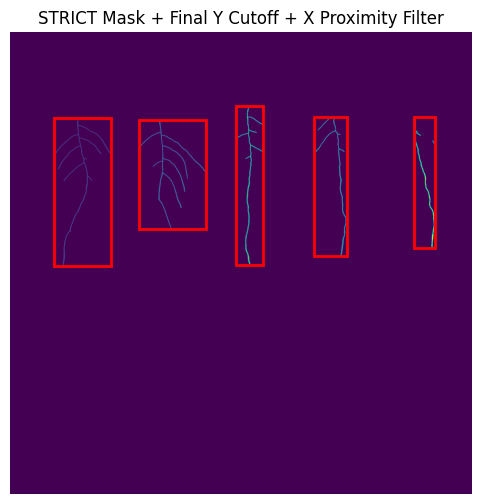

In [5]:
from scipy.ndimage import label

def calculate_iou(box1, box2):
    """
    Calculate the Intersection over Union (IoU) of two bounding boxes.
    
    Parameters:
        box1 (tuple): Bounding box 1 (x_min, y_min, x_max, y_max).
        box2 (tuple): Bounding box 2 (x_min, y_min, x_max, y_max).
    
    Returns:
        float: IoU value.
    """
    x_min = max(box1[0], box2[0])
    y_min = max(box1[1], box2[1])
    x_max = min(box1[2], box2[2])
    y_max = min(box1[3], box2[3])

    # Calculate intersection area
    inter_width = max(0, x_max - x_min)
    inter_height = max(0, y_max - y_min)
    inter_area = inter_width * inter_height

    # Calculate area of both bounding boxes
    area_box1 = (box1[2] - box1[0]) * (box1[3] - box1[1])
    area_box2 = (box2[2] - box2[0]) * (box2[3] - box2[1])

    # Calculate union area
    union_area = area_box1 + area_box2 - inter_area

    # Compute IoU with better precision
    return round(inter_area / union_area, 6) if union_area > 0 else 0

def apply_strict_bboxes_with_top_cutoff_and_proximity(preprocessed_mask, original_mask, iou_threshold=0.001, size_threshold=2000, bottom_y_cutoff_ratio=0.85, top_y_cutoff=100, min_x_distance=20):
    """
    Apply bounding boxes to a single image with:
    - size + bottom cutoff
    - IoU suppression
    - post-filter top strip exclusion (y_min < top_y_cutoff)
    - post-filter proximity suppression (too-close boxes -> keep biggest)
    """
    from scipy.ndimage import label

    h, w = original_mask.shape
    bottom_cutoff = int(h * bottom_y_cutoff_ratio)

    labeled_preprocessed, num_labels = label(preprocessed_mask > 0)
    bboxes = []

    for comp_id in range(1, num_labels + 1):
        component = (labeled_preprocessed == comp_id)
        y_coords, x_coords = np.where(component)

        if len(x_coords) == 0 or len(y_coords) == 0:
            continue

        x_min, x_max = x_coords.min(), x_coords.max()
        y_min, y_max = y_coords.min(), y_coords.max()
        area = (x_max - x_min) * (y_max - y_min)

        if area >= size_threshold and y_min < bottom_cutoff:
            bboxes.append((x_min, y_min, x_max, y_max, comp_id, area))

    # --- IoU suppression ---
    bboxes = sorted(bboxes, key=lambda box: box[5], reverse=True)
    filtered = []
    for box in bboxes:
        keep = True
        for kept in filtered:
            if calculate_iou(box[:4], kept[:4]) > iou_threshold:
                if box[5] <= kept[5]:
                    keep = False
                    break
        if keep:
            filtered.append(box)

    # --- Post-filter: remove boxes intersecting top cutoff (y < 100) ---
    filtered = [box for box in filtered if box[1] >= top_y_cutoff]

    # --- Post-filter: remove boxes too close in X axis ---
    kept_indices = set(range(len(filtered)))
    for i in range(len(filtered)):
        if i not in kept_indices:
            continue
        x_min_i, _, x_max_i, _, _, area_i = filtered[i]
        for j in range(i + 1, len(filtered)):
            if j not in kept_indices:
                continue
            x_min_j, _, x_max_j, _, _, area_j = filtered[j]

            # Compute horizontal gap (can be negative if overlapping)
            x_gap = min(abs(x_min_i - x_max_j), abs(x_min_j - x_max_i))
            if x_gap < min_x_distance:
                if area_i >= area_j:
                    kept_indices.discard(j)
                else:
                    kept_indices.discard(i)
                    break  # i is removed, stop comparing it

    final = [filtered[k] for k in sorted(kept_indices)]


    # --- Create labeled mask ---
    labeled_output = np.zeros_like(original_mask, dtype=np.uint16)
    for box_idx, (x_min, y_min, x_max, y_max, _, _) in enumerate(final, start=1):
        region = original_mask[y_min:y_max + 1, x_min:x_max + 1]
        labeled_region, _ = label(region > 0)
        for cid in range(1, labeled_region.max() + 1):
            comp = (labeled_region == cid)
            labeled_output[y_min:y_max + 1, x_min:x_max + 1][comp] = box_idx

    # --- Visualization ---
    plt.figure(figsize=(6, 6))
    plt.imshow(labeled_output, cmap="viridis")
    plt.title("STRICT Mask + Final Y Cutoff + X Proximity Filter")
    plt.axis("off")
    for box in final:
        x_min, y_min, x_max, y_max, *_ = box
        plt.gca().add_patch(plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                                          edgecolor="red", fill=False, linewidth=2))
    plt.show()

    return labeled_output, final

final_labeled_mask, filtered_bboxes = apply_strict_bboxes_with_top_cutoff_and_proximity(
    preprocessed_mask,
    predicted_mask,
    iou_threshold=0.001,
    size_threshold=2000,
    bottom_y_cutoff_ratio=0.85,
    top_y_cutoff=100,
    min_x_distance=20
)

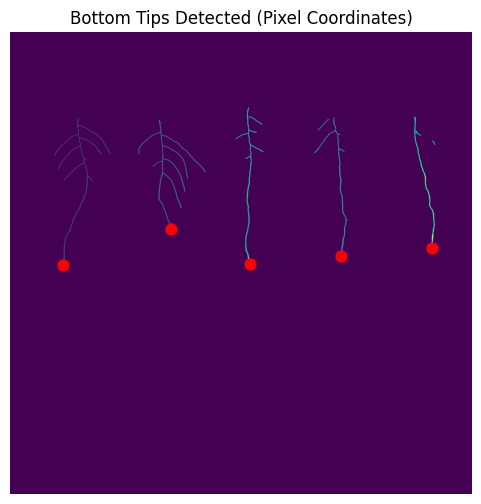

In [6]:
from skimage.morphology import skeletonize
from skan.csr import skeleton_to_csgraph
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

def extract_bottom_tips(labeled_mask):
    """
    Extract bottom tips (max y) from each labeled root in the skeletonized mask.
    Only includes roots whose top node is in the top half of the image.
    Returns a list of (y, x) coordinates in pixel space.
    """
    tips = []
    skeleton = skeletonize(labeled_mask > 0)
    root_ids = np.unique(labeled_mask)
    root_ids = root_ids[root_ids > 0]
    h, _ = labeled_mask.shape
    half_height = h // 2

    for root_id in root_ids:
        root_skel = (labeled_mask == root_id) & skeleton
        graph, coords = skeleton_to_csgraph(root_skel)
        G = nx.Graph()
        for i, j in zip(*graph.nonzero()):
            G.add_edge(i, j, weight=graph[i, j])
        try:
            top_node = min(G.nodes, key=lambda n: coords[0][n])    # min y (top)
            bottom_node = max(G.nodes, key=lambda n: coords[0][n]) # max y (bottom)
            top_y = coords[0][top_node]

            # === Filter: Only accept roots starting above halfway point ===
            if top_y < half_height:
                tip_y = coords[0][bottom_node]
                tip_x = coords[1][bottom_node]
                tips.append((tip_y, tip_x))
        except:
            continue

    return tips

# Run and visualize
bottom_tips_px = extract_bottom_tips(final_labeled_mask)

plt.figure(figsize=(6, 6))
plt.imshow(final_labeled_mask, cmap='viridis')
plt.title("Bottom Tips Detected (Pixel Coordinates)")
for y, x in bottom_tips_px:
    plt.scatter(x, y, color='red', s=60)
plt.axis("off")
plt.show()


## Initialize Simulation + PID Inoculation from CV Output

In [7]:
from PID_Controller import PID
import numpy as np

# === Conversion: from pixel space to robot space ===
plate_size_mm = 150
plate_size_px = padded_image.shape[0]
conversion_factor = plate_size_mm / plate_size_px / 1000  # mm → meters
print(f"[INFO] px→m conversion factor: {conversion_factor:.6f}")

plate_origin_robot = np.array([0.10775, 0.088 - 0.026, 0.057])

# Convert bottom tips to robot-space coordinates (swap x/y due to rotation)
robot_goals = []
for (y_px, x_px) in bottom_tips_px:
    x_robot = plate_origin_robot[0] + y_px * conversion_factor  # y_px → X
    y_robot = plate_origin_robot[1] + x_px * conversion_factor  # x_px → Y
    z_robot = plate_origin_robot[2]
    robot_goals.append(np.array([x_robot, y_robot, z_robot]))

print(f"[INFO] Converted {len(robot_goals)} root tips to robot-space goals.")

# === Reuse existing simulation and initialize PID ===
pid_x = PID(5, 0.1, 0.01)
pid_y = PID(5, 0.1, 0.01)
pid_z = PID(5, 0.1, 0.01)

DT = 0.01
TOL = 0.001  # 1mm XY tolerance
VEL_SCALE = 5.0

# === Inoculate each root tip ===
for i, target in enumerate(robot_goals):
    print(f"\n[INOCULATE] Root {i+1}/{len(robot_goals)} → Target: {target.round(5)}")
    has_dropped = False

    for step in range(500):

        # === Record frame after every step ===
        width, height, rgbImg, _, _ = p.getCameraImage(
            width=320, height=240,
            viewMatrix=p.computeViewMatrix(cameraEyePosition=[1, 0, 1],
                                        cameraTargetPosition=[-0.3, 0, 0],
                                        cameraUpVector=[0, 0, 1]),
            projectionMatrix=p.computeProjectionMatrixFOV(
                fov=60, aspect=320/240, nearVal=0.1, farVal=100.0
            )
        )
        frame = np.reshape(rgbImg, (height, width, 4))[:, :, :3]
        frames.append(frame)

        state = sim.get_states()
        robot_key = list(state.keys())[0]
        current_pos = np.array(state[robot_key]["pipette_position"], dtype=float)
        error = target - current_pos

        xy_error = np.linalg.norm(error[:2])

        if not has_dropped and xy_error < TOL:
            print(f"[✓] Tip {i+1} reached (XY) | Dropping.")
            sim.run([[0, 0, 0, 1]], num_steps=1)  # Drop
            has_dropped = True
            break

        # PID control
        vx = VEL_SCALE * pid_x.compute(target[0], current_pos[0], DT)
        vy = VEL_SCALE * pid_y.compute(target[1], current_pos[1], DT)
        vz = VEL_SCALE * pid_z.compute(target[2], current_pos[2], DT)

        sim.run([[vx, vy, vz, 0]], num_steps=1)

    if not has_dropped:
        print(f"[✗] Tip {i+1} NOT reached | Final XY error: {xy_error:.5f} m")

print("[POST] Lifting pipette to show final result...")
for step in range(50):
    sim.run([[0, 0, 0.05, 0]], num_steps=1)  # Small upward motion in z

sim.close()
print("[SIM] Finished all inoculations and closed.")


[INFO] px→m conversion factor: 0.000053
[INFO] Converted 5 root tips to robot-space goals.

[INOCULATE] Root 1/5 → Target: [0.18259 0.07899 0.057  ]
[✓] Tip 1 reached (XY) | Dropping.

[INOCULATE] Root 2/5 → Target: [0.17098 0.11367 0.057  ]
[✓] Tip 2 reached (XY) | Dropping.

[INOCULATE] Root 3/5 → Target: [0.17966 0.16811 0.057  ]


TypeError: cannot unpack non-iterable NoneType object

## Saving GIF